In [1]:
import numpy as np
import math
from qiskit.circuit import QuantumCircuit,QuantumRegister
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer,FreezeCoreTransformer
import numpy as np
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from copy import  deepcopy
from qiskit.circuit import Parameter,ParameterVector
import sys
sys.path.append('..')
# from AdaptVQE_.My_adapt import QubitAdapt,MyAdaptVQE
from AdaptVQE_.MyQubit_Adapt_VQE import QubitAdapt
from AdaptVQE_.My_adapt import MyAdaptVQE
# Define Molecule
molecule = MoleculeInfo(
    ["H", "H"], [(0.0, 0.0, 0.0), (0.8*1, 0.0, 0.0)],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)
driver = PySCFDriver().from_molecule(molecule)

problem = driver.run()
converter = QubitConverter(JordanWignerMapper(), two_qubit_reduction=True)
transformer = FreezeCoreTransformer(
    freeze_core=True,  # how many electrons we have in our active space
    # how many orbitals we have in our active space
    remove_orbitals=[-3, -2]
)
#problem = transformer.transform(problem=problem)

In [2]:
from qiskit.quantum_info import SparsePauliOp
#a = MyAdaptVQE(ES_problem=problem)
b = QubitAdapt(ES_problem=problem)


logger init done!
完整池320,Propotion=0.25,实际池80
开始初始化:挑选第一个算符...
初始化结果:第16项被选定,此项梯度最大,为0.24593734848357293


In [2]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD,UCC

uccsd = UCCSD(qubit_converter=QubitConverter(JordanWignerMapper()),
              num_particles=problem.num_particles,
              num_spatial_orbitals=problem.num_spatial_orbitals,
              initial_state=HartreeFock(num_particles=problem.num_particles,num_spatial_orbitals=problem.num_spatial_orbitals,qubit_converter=converter),
              generalized=False  # 如果设为True ==> UCCGSD G=generalized
              )

print(f'H2的SD激发列表是:{uccsd.excitation_list},\nH2的激发费米子算符是:\n{uccsd.excitation_ops()}\n{uccsd.decompose().draw()}')

H2的SD激发列表是:[((0,), (1,)), ((2,), (3,)), ((0, 2), (1, 3))],
H2的激发费米子算符是:
[FermionicOp({'+_0 -_1': 1j, '+_1 -_0': (-0-1j)}, num_spin_orbitals=4, ), FermionicOp({'+_2 -_3': 1j, '+_3 -_2': (-0-1j)}, num_spin_orbitals=4, ), FermionicOp({'+_0 +_2 -_1 -_3': 1j, '+_3 +_1 -_2 -_0': (-0-1j)}, num_spin_orbitals=4, )]
     ┌───┐┌───────────────────────────────────┐»
q_0: ┤ X ├┤0                                  ├»
     └───┘│                                   │»
q_1: ─────┤1                                  ├»
     ┌───┐│  exp(-it (IIXY + IIYX))(1.0*t[0]) │»
q_2: ┤ X ├┤2                                  ├»
     └───┘│                                   │»
q_3: ─────┤3                                  ├»
          └───────────────────────────────────┘»
«     ┌───────────────────────────────────┐»
«q_0: ┤0                                  ├»
«     │                                   │»
«q_1: ┤1                                  ├»
«     │  exp(-it (XYII + YXII))(1.0*t[1]) │»
«q_2: ┤2                  

In [15]:
op=uccsd.excitation_ops()
i,k = op[0].terms()
i

([('+', 0), ('-', 1)], 1j)

In [17]:
op[0]
uccsd.excitation_list

[((0,), (1,)), ((2,), (3,)), ((0, 2), (1, 3))]

In [88]:
op = uccsd.excitation_ops()
print(f'T1={op[0]},\nT1_dagger={op[0].transpose()}')
tmp = op[0]-op[0].transpose()
converter.convert(op[0])

T1=Fermionic Operator
number spin orbitals=4, number terms=2
  1j * ( +_0 -_1 )
+ (-0-1j) * ( +_1 -_0 ),
T1_dagger=Fermionic Operator
number spin orbitals=4, number terms=2
  1j * ( +_1 -_0 )
+ (-0-1j) * ( +_0 -_1 )


PauliSumOp(SparsePauliOp(['IIXY', 'IIYX'],
              coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0)

In [158]:
converter.convert(tmp)
EvolvedOperatorAnsatz(converter.convert(tmp)).decompose(reps=3).draw()

┌─────┐┌───┐┌───┐┌──────────────┐┌───┐┌───┐ ┌───┐ ┌───┐┌───┐»
q_0: ┤ Sdg ├┤ H ├┤ X ├┤ Rz(2.0*t[0]) ├┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├»
     └┬───┬┘└───┘└─┬─┘└──────────────┘└─┬─┘├───┤┌┴───┴┐├───┤└─┬─┘»
q_1: ─┤ H ├────────■────────────────────■──┤ H ├┤ Sdg ├┤ H ├──■──»
      └───┘                                └───┘└─────┘└───┘     »
q_2: ────────────────────────────────────────────────────────────»
                                                                 »
q_3: ────────────────────────────────────────────────────────────»
                                                                 »
«     ┌───────────────┐┌───┐┌───┐     
«q_0: ┤ Rz(-2.0*t[0]) ├┤ X ├┤ H ├─────
«     └───────────────┘└─┬─┘├───┤┌───┐
«q_1: ───────────────────■──┤ H ├┤ S ├
«                           └───┘└───┘
«q_2: ────────────────────────────────
«                                     
«q_3: ────────────────────────────────
«

In [105]:
from qiskit_nature.second_q.operators import FermionicOp
k = FermionicOp({'+_0 -_1': 1j}, num_spin_orbitals=4,)
a = converter.convert(k)
converter.convert(k)
b = converter.convert(k.transpose())
converter.convert(k.transpose())
print((a-b).reduce())

0.5 * IIXY
- 0.5 * IIYX


In [112]:
m = FermionicOp({'+_1 -_0': 1j}, num_spin_orbitals=4,)
a = converter.convert(m-m.transpose())
a

PauliSumOp(SparsePauliOp(['IIXY', 'IIYX'],
              coeffs=[-0.5+0.j,  0.5+0.j]), coeff=1.0)

In [109]:
(a-b).reduce()

PauliSumOp(SparsePauliOp(['IIXY', 'IIYX', 'IIXX', 'IIYY'],
              coeffs=[ 0.25+0.5j , -0.25-0.5j ,  0.  -0.25j,  0.  -0.25j]), coeff=1.0)

In [104]:
(a-b)

PauliSumOp(SparsePauliOp(['IIXY', 'IIYY', 'IIXX', 'IIYX', 'IIXY', 'IIXX', 'IIYY', 'IIYX'],
              coeffs=[ 0.25+0.j  ,  0.  +0.25j,  0.  +0.25j, -0.25+0.j  ,  0.25+0.j  ,
  0.  -0.25j,  0.  -0.25j, -0.25+0.j  ]), coeff=1)

In [90]:
problem.num_spatial_orbitals
HartreeFock(num_particles=problem.num_particles,num_spatial_orbitals=problem.num_spatial_orbitals,qubit_converter=converter).draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

In [ ]:
X =b.run_slover()

In [134]:
x = uccsd.decompose()[2]
qc = QuantumCircuit(4)
qc.append(x,range(4))
print(f'{qc.draw()}\n{qc.decompose().draw()}\n{qc.decompose(reps=2).draw()}')

     ┌───────────────────────────────────┐
q_0: ┤0                                  ├
     │                                   │
q_1: ┤1                                  ├
     │  exp(-it (IIXY + IIYX))(1.0*t[0]) │
q_2: ┤2                                  ├
     │                                   │
q_3: ┤3                                  ├
     └───────────────────────────────────┘
     ┌─────────────────────┐┌─────────────────────┐
q_0: ┤0                    ├┤0                    ├
     │                     ││                     │
q_1: ┤1                    ├┤1                    ├
     │  exp(it IIXY)(t[0]) ││  exp(it IIYX)(t[0]) │
q_2: ┤2                    ├┤2                    ├
     │                     ││                     │
q_3: ┤3                    ├┤3                    ├
     └─────────────────────┘└─────────────────────┘
     ┌─────┐┌───┐┌───┐┌──────────────┐┌───┐┌───┐ ┌───┐ ┌───┐┌───┐»
q_0: ┤ Sdg ├┤ H ├┤ X ├┤ Rz(1.0*t[0]) ├┤ X ├┤ H ├─┤ S ├─┤ H ├┤ X ├»
     └┬───┬

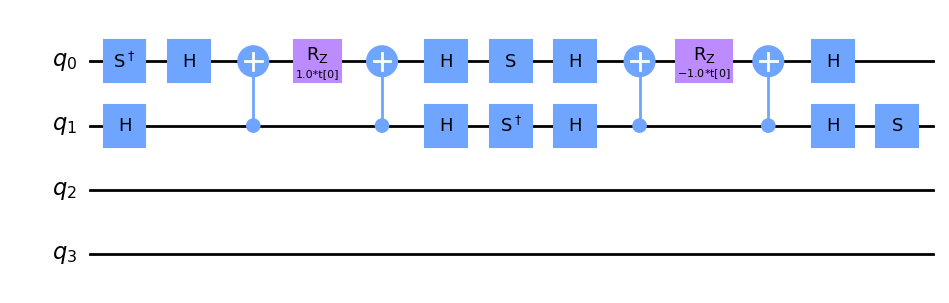

In [135]:
qc.decompose(reps=2).draw('mpl')

In [153]:
T11 = FermionicOp({'+_1 -_0': 1j, '+_0 -_1': (0-1j)}, num_spin_orbitals=4, )
T11_dagger = T11.transpose()
T1 = T11 - T11_dagger
T11_dagger


FermionicOp({'+_0 -_1': 1j, '+_1 -_0': -1j}, num_spin_orbitals=4, )

In [146]:
converter.convert(T1)

PauliSumOp(SparsePauliOp(['IIXY', 'IIYX'],
              coeffs=[-1.+0.j,  1.+0.j]), coeff=1.0)

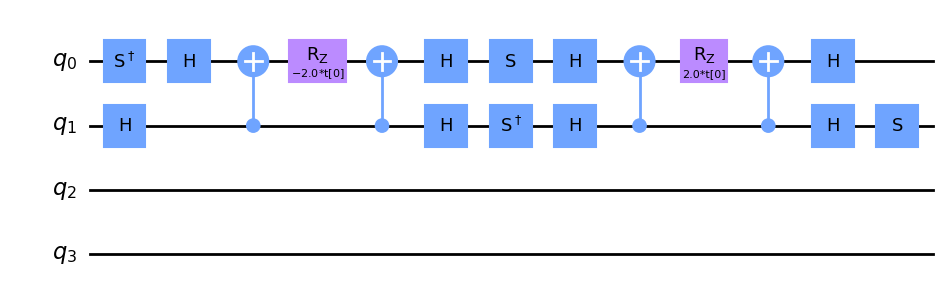

In [152]:
from qiskit.circuit.library import EvolvedOperatorAnsatz
EvolvedOperatorAnsatz(converter.convert(T1)).decompose(reps=3).draw('mpl')